In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from distance import *
from utils import *

In [3]:
def get_hists(dist, bins=100):
    res = np.zeros(bins)
    for filename in glob("data/poland_warszawa_2023_*.pb"):
        print(filename)
        X = load_pb_ohe(filename)[2]
        hist, bin_edges = np.histogram(
            dist(X),
            bins=bins,
            range=(0,1),
        )
        assert res.shape == hist.shape
        res += hist / hist.sum()
    return res

In [4]:
print(f"{"rodzaj":40}, {"liczba projektów":16}, {"liczba głosów":13}")
for filename in glob("data/poland_warszawa_2023*.pb"):
    meta = load_pb(filename)[0]
    print(f"{meta['description']:40}, {meta['num_projects']:16}, {meta['num_votes']:13}")

rodzaj                                  , liczba projektów, liczba głosów
District PB in Warsaw, Bemowo           ,               83,          5180
District PB in Warsaw, Białołęka        ,               72,          9173
District PB in Warsaw, Bielany          ,               98,          4956
District PB in Warsaw, Mokotów          ,               81,         11067
District PB in Warsaw, Ochota           ,               81,          4392
District PB in Warsaw, Praga-Północ     ,               91,          2818
District PB in Warsaw, Praga-Południe   ,               81,          8922
District PB in Warsaw, Rembertów        ,               38,          1172
District PB in Warsaw, Śródmieście      ,               47,          3883
District PB in Warsaw, Targówek         ,               97,          4680
District PB in Warsaw, Ursus            ,               72,          4519
District PB in Warsaw, Ursynów          ,               64,          6260
District PB in Warsaw, Wawer          

In [14]:
def sample_jaccard(X, size):
    xs = X[np.random.choice(X.shape[0], size=size)]
    ys = X[np.random.choice(X.shape[0], size=size)]
    return 1 - np.minimum(xs, ys).sum(axis=-1) / np.maximum(xs, ys).sum(axis=-1)
def sample_cosine(X, size):
    xs = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    ys = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    return 1 - (xs * ys).sum(axis=-1)
def sample_all(X, size):
    return np.array([sample_jaccard(X, size), sample_cosine(X, size)])

In [6]:
districts = [
    "bemowo",
    "bialoleka",
    "bielany",
    "mokotow",
    "ochota",
    "praga-polnoc",
    "praga-poludnie",
    "rembertow",
    "srodmiescie",
    "targowek",
    "ursus",
    "ursynow",
    "wawer",
    "wesola",
    "wilanow",
    "wlochy",
    "wola",
    "zoliborz",
]
filenames = [
    f"data/poland_warszawa_2023_{district}.pb"
    for district in districts
]

In [15]:
sample_size = 1000000
distances = np.array([
    sample_all(load_pb_ohe(filename)[2], sample_size)
    for filename in filenames
])

In [9]:
distances.shape

(18, 2, 1000000)

Text(0.5, 1.0, 'Cosine')

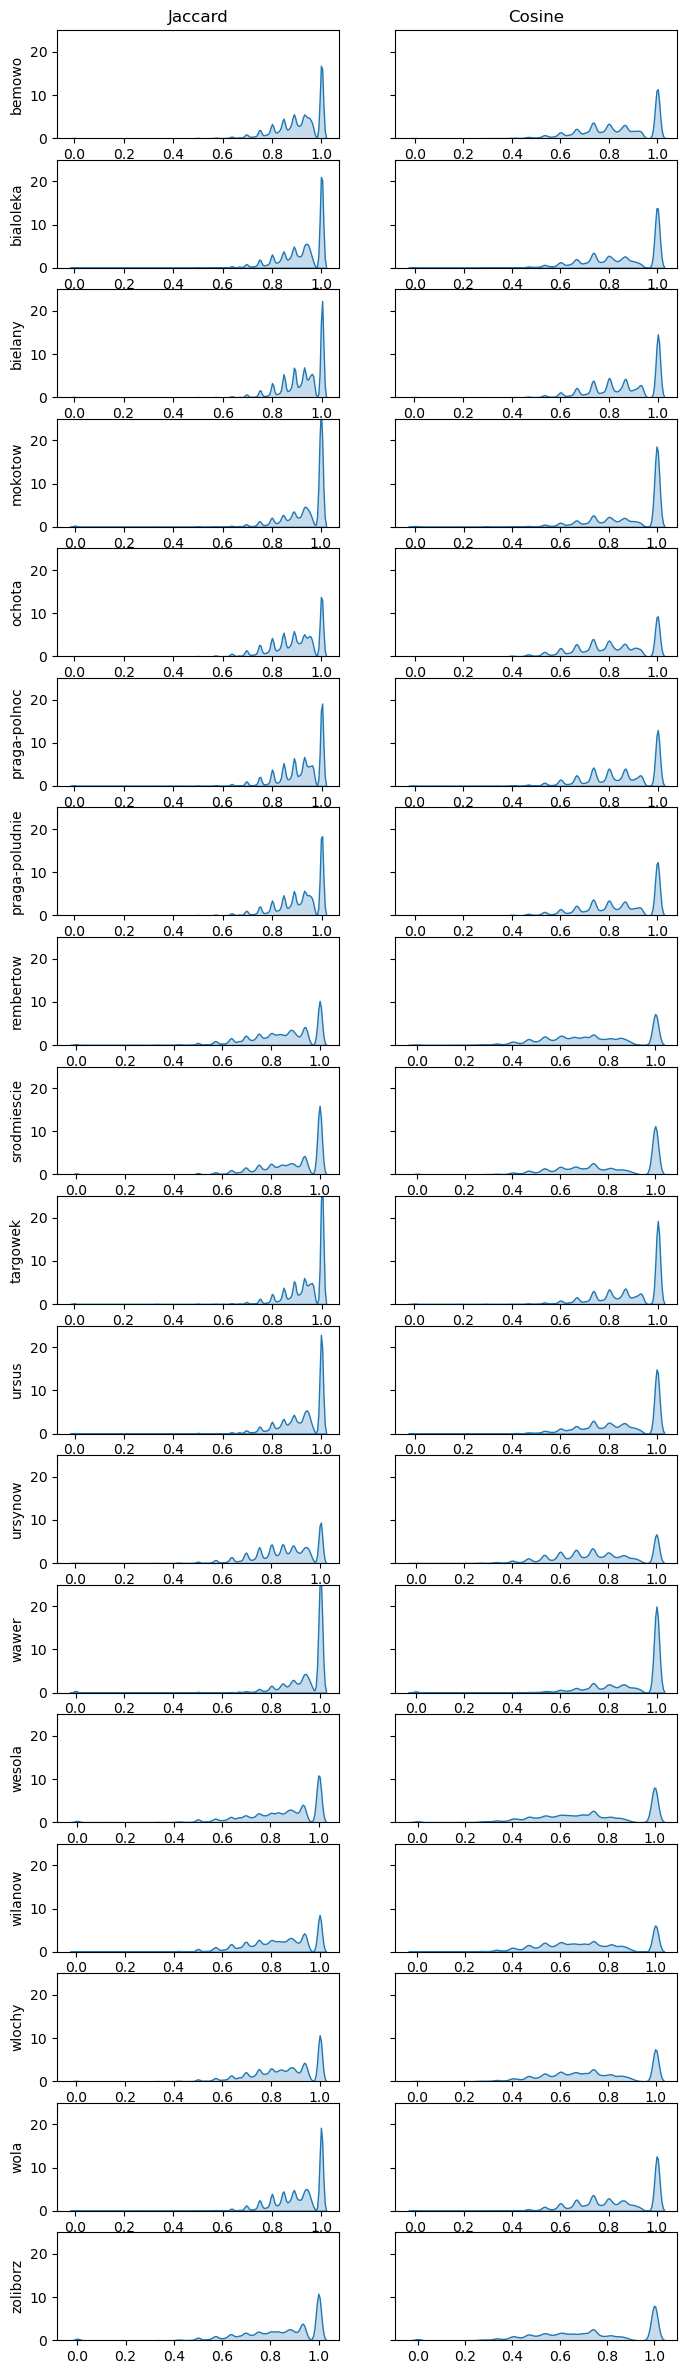

In [20]:
rows = distances.shape[0]
cols = distances.shape[1]
fig, axs = plt.subplots(
    nrows=rows,
    ncols=cols,
    sharey='row',
    figsize=(8,30),
)
for i, (dists, district) in enumerate(zip(distances, districts)):
    for j, dist in enumerate(dists):
        sns.kdeplot(
            dist,
            fill=True,
            ax=axs[i,j]
        )
        axs[i,j].set_ylim(0, 25)
        axs[i,j].set_ylabel(district)
axs[0,0].set_title("Jaccard")
axs[0,1].set_title("Cosine")

In [24]:
meta, projects, votes = load_pb_ohe('data/poland_warszawa_2023_srodmiescie.pb')
votesT = votes.T

In [25]:
d_v_jaccard = jaccard(votes, votes)
d_v_cosine = cosine(votes, votes)
d_v_chord = chord(votes, votes) / np.sqrt(2)
d_v_simrank = simrank(votes, 0.95, 0.95, max_iter=1000)
d_p_jaccard = jaccard(votesT, votesT)
d_p_cosine = cosine(votesT, votesT)
d_p_chord = chord(votesT, votesT) / np.sqrt(2)
d_p_simrank = simrank(votesT, 0.95, 0.95, max_iter=1000)

Iteration 0 norm is (266.96468897912587, 0.01596115435779917)
Iteration 1 norm is (1.100617662582525, 1.0864936225224604)
Iteration 2 norm is (85.91226591138785, 0.013077529216718306)
Iteration 3 norm is (0.9914276338795591, 0.9887663445359907)
Iteration 4 norm is (76.0681947481709, 0.011485838907528953)
Iteration 5 norm is (0.8802183403234737, 0.8738868868266322)
Iteration 6 norm is (67.2096709408579, 0.010085807390012923)
Iteration 7 norm is (0.7758832783700612, 0.7680169492243591)
Iteration 8 norm is (59.1486022311912, 0.008854494026628796)
Iteration 9 norm is (0.6821751606151283, 0.6743326179396849)
Iteration 10 norm is (51.97379055686821, 0.007772917605214477)
Iteration 11 norm is (0.5992065836174089, 0.5919697860626454)
Iteration 12 norm is (45.64172103696124, 0.006823271984359291)
Iteration 13 norm is (0.5261284909372886, 0.5196460718014128)
Iteration 14 norm is (40.07146629979548, 0.005989587131921101)
Iteration 15 norm is (0.4618916470942758, 0.4561536845254557)
Iteration 16 n

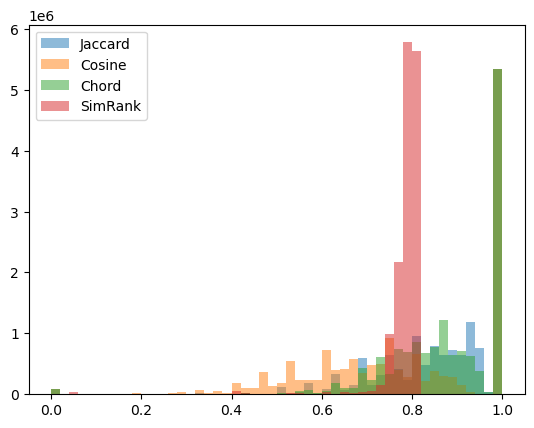

In [26]:
args = {"bins": 50, "alpha": 0.5, "range": (0, 1)}
plt.hist(d_v_jaccard.reshape(-1), label="Jaccard", **args)
plt.hist(d_v_cosine.reshape(-1), label="Cosine", **args)
plt.hist(d_v_chord.reshape(-1), label="Chord", **args)
plt.hist(d_v_simrank.reshape(-1), label="SimRank", **args)
plt.legend()
plt.show()

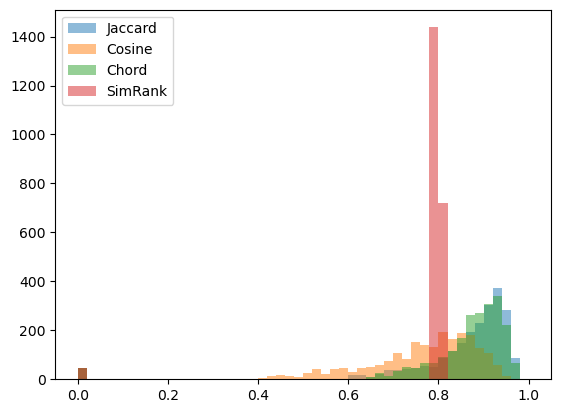

In [27]:
args = {"bins": 50, "alpha": 0.5, "range": (0, 1)}
plt.hist(d_p_jaccard.reshape(-1), label="Jaccard", **args)
plt.hist(d_p_cosine.reshape(-1), label="Cosine", **args)
plt.hist(d_p_chord.reshape(-1), label="Chord", **args)
plt.hist(d_p_simrank.reshape(-1), label="SimRank", **args)
plt.legend()
plt.show()

In [32]:
corr = pd.DataFrame({
    "Jaccard": d_v_jaccard.reshape(-1),
    "Cosine": d_v_cosine.reshape(-1),
    "Chord": d_v_chord.reshape(-1),
    "Simrank": d_v_simrank.reshape(-1),
}).corr()
corr

,Jaccard,Cosine,Chord,Simrank
Jaccard,1.000000,0.957265,0.984056,0.644516
Cosine,0.957265,1.000000,0.971437,0.575043
Chord,0.984056,0.971437,1.000000,0.709583
Simrank,0.644516,0.575043,0.709583,1.000000


In [ ]:
corr = pd.DataFrame({
    "Jaccard": d_p_jaccard.reshape(-1),
    "Cosine": d_p_cosine.reshape(-1),
    "Chord": d_p_chord.reshape(-1),
    "Simrank": d_p_simrank.reshape(-1),
}).corr()
corr

,Jaccard,Cosine,Chord,Simrank
Jaccard,1.000000,0.957265,0.984056,0.644516
Cosine,0.957265,1.000000,0.971437,0.575043
Chord,0.984056,0.971437,1.000000,0.709583
Simrank,0.644516,0.575043,0.709583,1.000000
